# From snippets to model

## General imports

In [16]:
%%time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import pickle

import librosa
import librosa.display
from librosa.effects import time_stretch, pitch_shift
import audiomentations as AA
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve

import xgboost as xgb

CPU times: user 43 µs, sys: 292 µs, total: 335 µs
Wall time: 338 µs


## Setting up folder path

In [17]:
folder = '/Users/rblc/code/iamrblc/laica/audio/snippets/'

## Creating the base snippet dataframe

In [18]:
def snippet_df_maker(folder = folder):
    # Create empty lists to store the data
    file_names = []
    srs = []
    audios = []
    labels = []
    
    file_list = sorted(os.listdir(folder))
    
    for file in file_list:
        '''MAC creates a .DS_Store file in every folder, which causes an error
        this if statement skips the .DS_Store file'''
        if file.endswith('.wav'):                
            # load the audio file with librosa
            audio, sr = librosa.load(os.path.join(folder, file))
            
            # normalize the audio with librosa normalizer
            audio = librosa.util.normalize(audio)
            
            # split the filename into the label and ID columns
            label = file.split('_')[0]
            
            # append the extracted features to the lists
            file_names.append(file)
            srs.append(sr)
            audios.append(audio)
            labels.append(label)

            # convert the lists to a pandas dataframe
            df = pd.DataFrame(
                {'file_name':file_names,
                'sample_rate': srs,
                'audio': audios,
                'label': labels,})
            
            # add length column
            df['length'] = (df['audio'].apply(lambda x: len(x))/df['sample_rate'])
            
            # include only rows where length between 0.2 and 4 seconds
            df = df[df['length'] > 0.2]
            df = df[df['length'] < 4]
         
    return df

In [19]:
snippet_df = snippet_df_maker()

### Brief check

### Reduce df to the most important features

In [20]:
# Create df with only file_name, and label columns
snippet_df = snippet_df[['file_name', 'length', 'audio', 'label']]

### Quick check 

In [21]:
snippet_df.head()

,file_name,length,audio,label
0,bark_00001.wav,0.695964,"[0.023036616, 0.023904754, 0.02477289, 0.02347...",bark
1,bark_00004.wav,0.552018,"[0.0065075234, 0.005491715, 0.005364739, 0.004...",bark
2,bark_00005.wav,1.088027,"[0.0009460449, 0.001159668, 0.00091552734, 0.0...",bark
3,bark_00009.wav,0.991973,"[0.0, 0.0, -6.195211e-05, 0.0, 9.292817e-05, 0...",bark
4,bark_00012.wav,0.728027,"[-0.004835945, -0.006917238, -0.006090842, -0....",bark


In [22]:
# CHANGE THIS TO 4 SECONDS IN LIVE VERSION
# Create new df of audios between 0.2 and 4 seconds
snippet_df = snippet_df[(snippet_df['length'] >= 0.2) & (snippet_df['length'] <= 4)]


In [23]:
snippet_df.length.describe()

count    11150.000000
mean         1.086279
std          0.851764
min          0.201043
25%          0.423991
50%          0.800000
75%          1.480748
max          3.997007
Name: length, dtype: float64

(array([686., 798., 479., 300., 167., 393., 232., 239., 242., 299., 623.,
        244., 180., 200., 157., 441., 161., 161., 181., 146., 119., 364.,
        137., 114., 104., 109., 292., 106., 108.,  77.,  93., 248.,  94.,
         89.,  93.,  72., 189.,  50.,  54.,  73.,  45.,  56., 179.,  41.,
         51.,  50.,  48., 142.,  48.,  36.,  51.,  46., 132.,  36.,  38.,
         31.,  40., 120.,  32.,  25.,  32.,  18.,  29.,  82.,  39.,  24.,
         25.,  21.,  80.,  24.,  20.,  24.,  17.,  75.,  14.,  11.,  12.,
         14.,  19.,  64.,  15.,  20.,  15.,  10.,  59.,  18.,   9.,  14.,
         12.,  44.,  19.,   9.,  12.,  11.,  35.,  10.,  10.,   9.,   9.,
          5.]),
 array([0.20104308, 0.23900272, 0.27696236, 0.314922  , 0.35288163,
        0.39084127, 0.42880091, 0.46676054, 0.50472018, 0.54267982,
        0.58063946, 0.61859909, 0.65655873, 0.69451837, 0.732478  ,
        0.77043764, 0.80839728, 0.84635692, 0.88431655, 0.92227619,
        0.96023583, 0.99819546, 1.0361551 , 1.

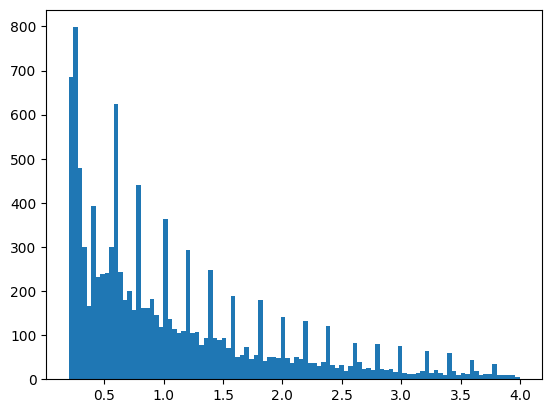

In [24]:
# histogram of lengths
plt.hist(snippet_df['length'], bins = 100)

In [25]:
snippet_df.shape

(11150, 4)

In [26]:
snippet_df.label.value_counts()

bark     5817
whine    2198
growl    1585
yelp      815
pant      735
Name: label, dtype: int64

## Augmenting data

In [27]:
augmented_df = snippet_df.copy()

In [28]:
max(augmented_df.label.value_counts())

5817

In [29]:
augmentation_pipeline = AA.Compose([
    AA.AddGaussianNoise(p=0.2, min_amplitude=0.001, max_amplitude=0.015),
    AA.TimeStretch(p = 0.2, min_rate=0.8, max_rate=1.2,),
    AA.PitchShift(p=0.3, min_semitones=-4, max_semitones=4),
    AA.Shift(p=0.3, min_fraction=-0.5, max_fraction=0.5)
])

default_augment = AA.AddGaussianNoise(p=1.0, min_amplitude=0.001, max_amplitude=0.015)

In [30]:
# PICK THE DESIRED TARGET NUMBER OF SAMPLES PER CLASS
#target_n = 4000                                    # 3000 samples per class
target_n = max(augmented_df.label.value_counts())  # adjusts all to the largest class


for label in augmented_df.label.unique():
    # create df from current label
    df_label = augmented_df[augmented_df['label'] == label].reset_index(drop=True)
    current_n = len(df_label)
    missing_n = target_n - current_n
    if missing_n > 0:
        for i in range(missing_n):
            # choose random row from df_label
            random_row = random.randint(0, current_n-1)
            # create augmented audio
            augmented_audio = augmentation_pipeline(df_label['audio'][random_row], sample_rate=22050)
            # check if any augmentations were applied
            if augmented_audio is None:
                # apply default augmentation
                augmented_audio = default_augment(df_label['audio'][random_row], sample_rate=22050)
            # create new row with augmented audio
            new_row = df_label.iloc[random_row].copy()
            new_row['audio'] = augmented_audio
            new_row['file_name'] = 'aug_' + new_row['file_name']
            # append new row to df
            augmented_df = augmented_df.append(new_row, ignore_index=True)


/var/folders/x2/6gs4vmmn5bxgqplmvj03kx240000gn/T/ipykernel_64850/2945261176.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(new_row, ignore_index=True)


In [31]:
augmented_df.label.value_counts()

bark     5817
growl    5817
pant     5817
whine    5817
yelp     5817
Name: label, dtype: int64

## Feature extraction


<span style="color:red;font-weight:bold">Use it only if you REALLY want to extract many audio features!!!! This takes loooooooong. </span>

In [32]:
def extract_features(row):
    file_path = os.path.join(folder, row['file_name'])
    y, sr = row['audio'], 22050
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    tonal_centroid = librosa.feature.tonnetz(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_flatness = librosa.feature.spectral_flatness(y=y)
    roll_off_frequency = librosa.feature.spectral_rolloff(y=y, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    chroma_vqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    rms_energy = librosa.feature.rms(y=y)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
    
    return mfcc, spectral_centroid, tonal_centroid, spectral_bandwidth, spectral_contrast, spectral_flatness, roll_off_frequency, chroma_stft, chroma_cqt, chroma_cens, chroma_vqt, mel_spectrogram, rms_energy, tonnetz, zero_crossing_rate

# Apply the function to each row in the dataframe
features = augmented_df.apply(extract_features, axis=1)
         
# Add the features to the dataframe as new columns
augmented_df['mfcc'] = features.apply(lambda x: x[0])                   
augmented_df['spectral_centroid'] = features.apply(lambda x: x[1])
augmented_df['tonal_centroid'] = features.apply(lambda x: x[2])
augmented_df['spectral_bandwidth'] = features.apply(lambda x: x[3])
augmented_df['spectral_contrast'] = features.apply(lambda x: x[4])
augmented_df['spectral_flatness'] = features.apply(lambda x: x[5])
augmented_df['roll_off_frequency'] = features.apply(lambda x: x[6])
augmented_df['chroma_stft'] = features.apply(lambda x: x[7])
augmented_df['chroma_cqt'] = features.apply(lambda x: x[8])
augmented_df['chroma_cens'] = features.apply(lambda x: x[9])
augmented_df['chroma_vqt'] = features.apply(lambda x: x[10])
augmented_df['mel_spectrogram'] = features.apply(lambda x: x[11])
augmented_df['rms_energy'] = features.apply(lambda x: x[12])
augmented_df['tonnetz'] = features.apply(lambda x: x[13])
augmented_df['zero_crossing_rate'] = features.apply(lambda x: x[14])

/Users/rblc/.pyenv/versions/3.10.6/envs/laica/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
/Users/rblc/.pyenv/versions/3.10.6/envs/laica/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=480
  return f(*args, **kwargs)
/Users/rblc/.pyenv/versions/3.10.6/envs/laica/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=240
  return f(*args, **kwargs)
/Users/rblc/.pyenv/versions/3.10.6/envs/laica/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=761
  return f(*args, **kwargs)
/Users/rblc/.pyenv/versions/3.10.6/envs/laica/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=381
  return f(*args, 

In [33]:
augmented_df.columns

Index(['file_name', 'length', 'audio', 'label', 'mfcc', 'spectral_centroid',
       'tonal_centroid', 'spectral_bandwidth', 'spectral_contrast',
       'spectral_flatness', 'roll_off_frequency', 'chroma_stft', 'chroma_cqt',
       'chroma_cens', 'chroma_vqt', 'mel_spectrogram', 'rms_energy', 'tonnetz',
       'zero_crossing_rate'],
      dtype='object')

In [34]:
# Saving to pickle

with open('all_features_raw.pkl', "wb") as file:
    pickle.dump(augmented_df, file)

## Feature engineering

In [35]:
engineered_df = augmented_df.copy()
engineered_df = engineered_df.drop(['audio', 'file_name', 'length'], axis=1)

In [36]:
engineered_df.head()

,label,mfcc,spectral_centroid,tonal_centroid,spectral_bandwidth,spectral_contrast,spectral_flatness,roll_off_frequency,chroma_stft,chroma_cqt,chroma_cens,chroma_vqt,mel_spectrogram,rms_energy,tonnetz,zero_crossing_rate
0,bark,"[[-250.46988, -118.261406, -44.761337, -15.150...","[[2046.2046259400604, 2099.150545524592, 2139....","[[-0.05564062640428977, -0.054857160710814444,...","[[2272.7644749065025, 2248.785409692656, 2173....","[[10.083532507545424, 15.717628307983748, 9.81...","[[0.015135139, 0.01321015, 0.012281442, 0.0118...","[[3531.4453125, 3585.2783203125, 3402.24609375...","[[1.0, 0.6266294, 0.47994635, 0.2713824, 0.375...","[[1.0, 0.761777, 0.5393927, 0.54491305, 0.8998...","[[0.40428674, 0.39814296, 0.39209375, 0.386269...","[[1.0, 0.761777, 0.5393927, 0.54491305, 0.8998...","[[0.012915908, 0.031311706, 0.028881935, 0.103...","[[0.07139338, 0.1563148, 0.23387022, 0.2687045...","[[-0.05564062640428977, -0.054857160710814444,...","[[0.0478515625, 0.0732421875, 0.10205078125, 0..."
1,bark,"[[-222.64336, -114.494804, -60.35255, -33.3058...","[[1423.8715011788172, 1619.1890493268447, 1854...","[[0.015897759385509306, 0.009007717110461624, ...","[[1871.10314692507, 1977.8849668595, 2087.5773...","[[15.767620112943057, 12.53210473618363, 7.647...","[[0.002488157, 0.0037870766, 0.005262599, 0.00...","[[1798.0224609375, 2121.0205078125, 2853.14941...","[[0.12100339, 0.11759795, 0.0656788, 0.1310568...","[[0.38791978, 0.43854693, 0.22183052, 0.338967...","[[0.2907964, 0.293968, 0.2970629, 0.3000109, 0...","[[0.38791978, 0.43854693, 0.22183052, 0.338967...","[[0.0011685492, 0.012247777, 0.010246476, 0.00...","[[0.11754749, 0.1978185, 0.25073367, 0.26931, ...","[[0.015897759385509306, 0.009007717110461624, ...","[[0.02734375, 0.04931640625, 0.08203125, 0.101..."
2,bark,"[[-176.08405, -18.083525, 42.982418, 33.61822,...","[[1609.62591927836, 1948.7073203481798, 2014.9...","[[-0.015406250679337048, -0.009881380995626738...","[[1535.0250645735653, 1846.5339566538146, 1910...","[[9.644357603893091, 7.285190595755207, 11.147...","[[0.004922074, 0.011850157, 0.014192977, 0.013...","[[2110.25390625, 3057.71484375, 3413.012695312...","[[0.19353837, 0.11841499, 0.11573104, 0.120078...","[[0.7320076, 0.49557084, 0.32487896, 0.2811330...","[[0.24546996, 0.24526928, 0.24507686, 0.244902...","[[0.7320076, 0.49557084, 0.32487896, 0.2811330...","[[0.005619203, 1.3658165, 6.378502, 4.3579183,...","[[0.19002177, 0.30884305, 0.38978156, 0.473680...","[[-0.015406250679337048, -0.009881380995626738...","[[0.05419921875, 0.080078125, 0.11279296875, 0..."
3,bark,"[[-175.92497, -88.45043, -67.50282, -94.0971, ...","[[1930.8328560150317, 1517.778187998585, 1375....","[[-0.0012710455864757947, -0.01302604855656250...","[[2313.0619044188634, 1738.5310795404746, 1456...","[[3.7725268295280836, 10.499280953845263, 15.7...","[[0.011582054, 0.0036919557, 0.0015853869, 0.0...","[[3057.71484375, 1798.0224609375, 1636.5234375...","[[0.54150945, 0.6418685, 0.18012051, 0.0116149...","[[0.65170974, 0.7272599, 0.41691503, 0.0877563...","[[0.33736077, 0.3405369, 0.3433404, 0.34583485...","[[0.65170974, 0.7272599, 0.41691503, 0.0877563...","[[0.0055523715, 0.0052145724, 0.0043094, 0.003...","[[0.14216626, 0.23925859, 0.29877156, 0.331212...","[[-0.0012710455864757947, -0.01302604855656250...","[[0.08642578125, 0.107421875, 0.1357421875, 0...."
4,bark,"[[-245.23177, -121.85542, -50.511383, -11.7700...","[[1566.8024789391602, 1853.0742714616822, 2026...","[[0.00782624757465723, 0.021310105574102033, -...","[[1963.8341808660134, 2081.2050402689824, 2070...","[[2.480265752183108, 6.236284359005937, 8.7809...","[[0.0062686424, 0.0078483755, 0.0074383565, 0....","[[2325.5859375, 2616.2841796875, 2777.78320312...","[[0.17328402, 0.23433262, 0.06043713, 0.043677...","[[0.45982212, 0.9552435, 0.31391752, 0.1673217...","[[0.2533056, 0.2546579, 0.25591376, 0.2570644,...","[[0.45982212, 0.9552435, 0.31391752, 0.1673217...","[[0.032042585, 0.05917298, 0.08950201, 0.30155...","[

In [37]:
def calculate_nested_stats(df, col_name):

    # Calculate median of first nested array only
    nested_median_func = lambda x: np.median(x[0])
    median_values = np.array(df[col_name].apply(nested_median_func).tolist())
    median_col_name = f"{col_name}_median"
    df[median_col_name] = pd.DataFrame(median_values)
    
    return df

for column_name in engineered_df.columns:
    if isinstance(engineered_df[column_name][0], np.ndarray):
        engineered_df = calculate_nested_stats(engineered_df, column_name)
        engineered_df = engineered_df.drop(columns = column_name)
        
engineered_df.head(2)


,label,mfcc_median,spectral_centroid_median,tonal_centroid_median,spectral_bandwidth_median,spectral_contrast_median,spectral_flatness_median,roll_off_frequency_median,chroma_stft_median,chroma_cqt_median,chroma_cens_median,chroma_vqt_median,mel_spectrogram_median,rms_energy_median,tonnetz_median,zero_crossing_rate_median
0,bark,-102.055176,1666.317100,-0.024824,1938.749922,11.108585,0.006765,2470.935059,0.37449,0.56505,0.343813,0.56505,0.147281,0.208743,-0.024824,0.08252
1,bark,-168.822693,1569.760056,-0.002689,1682.147827,12.479349,0.003832,2164.086914,0.17950,0.46824,0.316272,0.46824,0.003069,0.117684,-0.002689,0.08667


In [38]:
'''

THIS CODE CALCULATES THE MEDIAN OF EACH NESTED ARRAY INSTEAD OF JUST THE FIRST ONE
DON'T DELETE THIS YET. IT MIGHT BE USEFUL LATER


def calculate_nested_stats(df, col_name):

    # Calculate median values
    nested_median_func = lambda x: np.median(np.array(x), axis=1)
    median_values = np.array(df[col_name].apply(nested_median_func).tolist())
    num_cols = median_values.shape[1]
    median_col_names = [f"{col_name}_median_{i+1}" for i in range(num_cols)]
    df[median_col_names] = pd.DataFrame(median_values)
    
    return df

for column_name in engineered_df.columns:
    if isinstance(engineered_df[column_name][0], np.ndarray):
        engineered_df = calculate_nested_stats(engineered_df, column_name)
        engineered_df = engineered_df.drop(columns = column_name)
        
engineered_df.head(2)'''
pass

In [39]:
engineered_df.head()

,label,mfcc_median,spectral_centroid_median,tonal_centroid_median,spectral_bandwidth_median,spectral_contrast_median,spectral_flatness_median,roll_off_frequency_median,chroma_stft_median,chroma_cqt_median,chroma_cens_median,chroma_vqt_median,mel_spectrogram_median,rms_energy_median,tonnetz_median,zero_crossing_rate_median
0,bark,-102.055176,1666.317100,-0.024824,1938.749922,11.108585,0.006765,2470.935059,0.374490,0.565050,0.343813,0.565050,0.147281,0.208743,-0.024824,0.082520
1,bark,-168.822693,1569.760056,-0.002689,1682.147827,12.479349,0.003832,2164.086914,0.179500,0.468240,0.316272,0.468240,0.003069,0.117684,-0.002689,0.086670
2,bark,-117.979202,1553.578163,-0.004136,1570.977659,10.175662,0.004028,2088.720703,0.362602,0.579991,0.310145,0.579991,0.043794,0.216104,-0.004136,0.085938
3,bark,-124.172203,1370.298405,0.001403,1614.113058,10.939909,0.001585,1625.756836,0.443589,0.629050,0.376062,0.629050,0.008314,0.209051,0.001403,0.086426
4,bark,-94.421028,1634.525174,-0.034998,1755.269003,8.735654,0.004762,2207.153320,0.164390,0.541706,0.273086,0.541706,0.073518,0.207951,-0.034998,0.086670


In [40]:
# Write to pickle
with open('all_features_engineered.pkl', "wb") as file:
    pickle.dump(engineered_df, file)

## Preparation for the model

In [41]:
df = engineered_df.copy()

In [42]:
'''# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])'''

In [56]:
'''# Check label encoding
encoded_classes = dict(zip(le.classes_, le.transform(le.classes_)))
encoded_classes'''

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}

In [44]:
from sklearn.preprocessing import LabelEncoder

test_ratio = 0.2  # the percentage of data to be allocated to test set

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])  # add a new column for encoded labels

groups = df.groupby('label_encoded')

train_indices = []
test_indices = []

# loop over each group and split it into train and test
for _, group in groups:
    n = len(group)
    n_test = int(np.ceil(n * test_ratio))  # number of samples to be allocated to test set
    n_train = n - n_test  # number of samples to be allocated to train set
    indices = group.index.to_list()
    # shuffle indices to randomly select the samples for test and train sets
    np.random.shuffle(indices)
    test_indices += indices[:n_test]
    train_indices += indices[n_test:]

# create train and test dataframes
train_df = df.loc[train_indices]
test_df = df.loc[test_indices]


In [45]:
# Set X and y
X_train = train_df.drop(['label', 'label_encoded'], axis=1)
y_train = train_df['label_encoded']
X_test = test_df.drop(['label', 'label_encoded'], axis=1)
y_test = test_df['label_encoded']

In [46]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

## Saving the model

In [58]:
# Save the model to disk
filename = 'xgboost_model.pkl'
pickle.dump(model, open(filename, 'wb'))

## Testing the model

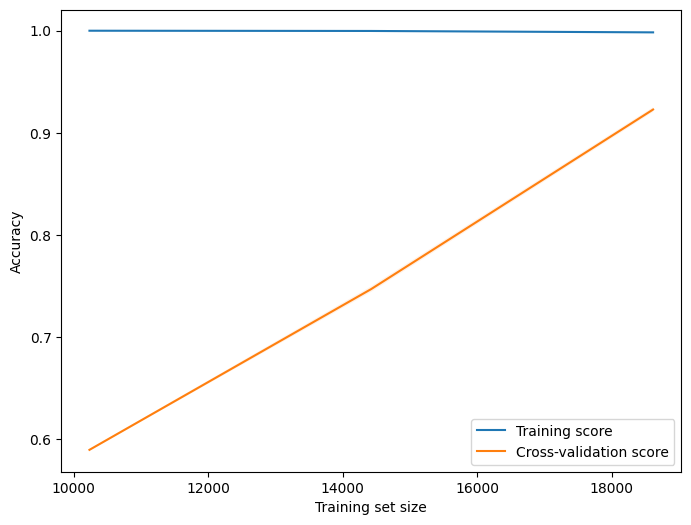

In [48]:
# Generate the learning curves using the trained model
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5)

# Plot the learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1), np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1)
plt.fill_between(train_sizes, np.mean(val_scores, axis=1) - np.std(val_scores, axis=1), np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), alpha=0.1)
plt.legend()
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.show()

In [49]:
y_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [50]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f" % accuracy)

Accuracy: 0.93


In [51]:
# Invert the encoded classes dictionary to get a mapping of class indices to their labels
class_labels = {v: k for k, v in encoded_classes.items()}

# Print the predicted probabilities for each class with their corresponding labels
for i, proba in enumerate(y_proba):
    print(f"Sample {i+1} predicted probabilities:")
    for j, p in enumerate(proba):
        class_label = class_labels[j]
        print(f"{class_label}: {p*100:.4f}")

Sample 1 predicted probabilities:
bark: 97.7242
growl: 0.5172
pant: 0.3213
whine: 1.4307
yelp: 0.0065
Sample 2 predicted probabilities:
bark: 98.7557
growl: 0.1614
pant: 1.0641
whine: 0.0179
yelp: 0.0009
Sample 3 predicted probabilities:
bark: 92.4645
growl: 0.0084
pant: 0.0028
whine: 1.9144
yelp: 5.6098
Sample 4 predicted probabilities:
bark: 98.3203
growl: 0.0172
pant: 0.0020
whine: 1.3752
yelp: 0.2852
Sample 5 predicted probabilities:
bark: 98.0786
growl: 0.0002
pant: 0.0003
whine: 0.3794
yelp: 1.5416
Sample 6 predicted probabilities:
bark: 99.9468
growl: 0.0370
pant: 0.0016
whine: 0.0077
yelp: 0.0069
Sample 7 predicted probabilities:
bark: 99.6282
growl: 0.2957
pant: 0.0053
whine: 0.0588
yelp: 0.0120
Sample 8 predicted probabilities:
bark: 55.6049
growl: 0.0126
pant: 0.3224
whine: 35.7555
yelp: 8.3045
Sample 9 predicted probabilities:
bark: 99.7115
growl: 0.0006
pant: 0.0125
whine: 0.1585
yelp: 0.1169
Sample 10 predicted probabilities:
bark: 99.4822
growl: 0.0016
pant: 0.0013
whine

In [55]:
y_proba = model.predict_proba(X_test)

# Define the encoded classes dictionary
encoded_classes = dict(zip(le.classes_, le.transform(le.classes_)))

# Invert the encoded classes dictionary to get a mapping of class indices to their labels
class_labels = {v: k for k, v in encoded_classes.items()}

# Print the predicted probabilities for each class with their corresponding labels and the actual label
for i, (proba, actual_label) in enumerate(zip(y_proba, y_test)):
    actual_label = le.inverse_transform([actual_label])[0]
    print(f"Sample {i+1} is a {actual_label}. The predicted probabilities:")
    for j, p in enumerate(proba):
        class_label = class_labels[j]
        print(f"{class_label}: {p*100:.4f}")

Sample 1 is a 0. The predicted probabilities:
0: 97.7242
1: 0.5172
2: 0.3213
3: 1.4307
4: 0.0065
Sample 2 is a 0. The predicted probabilities:
0: 98.7557
1: 0.1614
2: 1.0641
3: 0.0179
4: 0.0009
Sample 3 is a 0. The predicted probabilities:
0: 92.4645
1: 0.0084
2: 0.0028
3: 1.9144
4: 5.6098
Sample 4 is a 0. The predicted probabilities:
0: 98.3203
1: 0.0172
2: 0.0020
3: 1.3752
4: 0.2852
Sample 5 is a 0. The predicted probabilities:
0: 98.0786
1: 0.0002
2: 0.0003
3: 0.3794
4: 1.5416
Sample 6 is a 0. The predicted probabilities:
0: 99.9468
1: 0.0370
2: 0.0016
3: 0.0077
4: 0.0069
Sample 7 is a 0. The predicted probabilities:
0: 99.6282
1: 0.2957
2: 0.0053
3: 0.0588
4: 0.0120
Sample 8 is a 0. The predicted probabilities:
0: 55.6049
1: 0.0126
2: 0.3224
3: 35.7555
4: 8.3045
Sample 9 is a 0. The predicted probabilities:
0: 99.7115
1: 0.0006
2: 0.0125
3: 0.1585
4: 0.1169
Sample 10 is a 0. The predicted probabilities:
0: 99.4822
1: 0.0016
2: 0.0013
3: 0.1236
4: 0.3913
Sample 11 is a 0. The predic

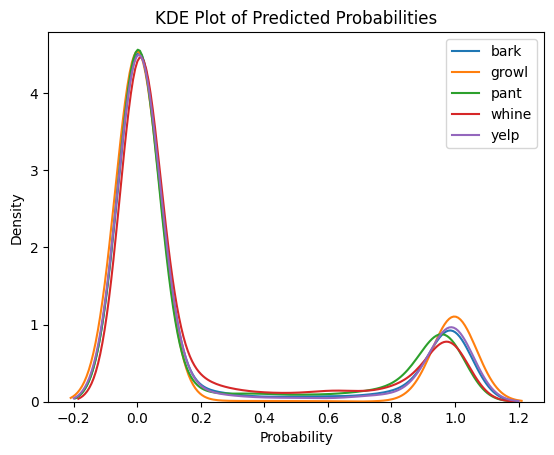

In [52]:
# Create a list of class labels for the legend
legend_labels = [class_labels[i] for i in range(len(class_labels))]

# Create a KDE plot for each class
for i in range(len(class_labels)):
    class_proba = y_proba[:, i]
    sns.kdeplot(class_proba, label=legend_labels[i])

# Set the plot title and axis labels
plt.title("KDE Plot of Predicted Probabilities")
plt.xlabel("Probability")
plt.ylabel("Density")

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()